In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate, interpolate
import casadi as ca

In [2]:
import pypei

In [85]:
V = 20

def single_jump_model(t, y, p):
    a, r = y[:2]
    *ps, g = p[:9]
    k1 = p[0]*ca.exp(p[1]*V)
    k2 = p[2]*ca.exp(-p[3]*V)
    k3 = p[4]*ca.exp(p[5]*V)
    k4 = p[6]*ca.exp(-p[7]*V)
    
    a_inf = k1/(k1+k2)
    tau_a = 1/(k1+k2)
    r_inf = k4/(k3+k4)
    tau_r = 1/(k3+k4)
    
    
    da = (a_inf - a)/tau_a
    dr = (r_inf - r)/tau_r
    
    return [
        da, 
        dr
    ]

In [4]:
EK = -80 

def obsv(t, y, p):
    # I
    a, r = y[:2]
    *ps, g = p[:9]
    return g * a * r * (V - EK)

In [86]:
tlim = [0, 2000]
y0 = [ # a, r
    0, 1]
p_true = [2.26e-4, 0.0699, 3.45e-5, 0.05462, 0.0873, 8.91e-3, 5.15e-3, 0.03158, 0.1524]

ar_sol = integrate.solve_ivp(single_jump_model, tlim, y0, args=[p_true], dense_output=True)

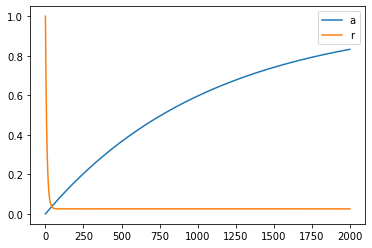

In [87]:
ts = np.linspace(*tlim, tlim[-1])

plt.figure()
plt.plot(ts, ar_sol.sol(ts).T, label=['a', 'r'])
# plt.yscale('symlog', linthresh=1e-3)
plt.legend()

Text(0.5, 0, 't (ms)')

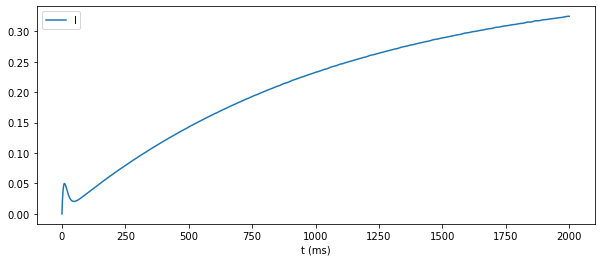

In [88]:
plt.figure(figsize=[10, 4])
plt.plot(ts, obsv(ts, ar_sol.sol(ts), p_true))
plt.legend('I')
plt.xlabel('t (ms)')

In [134]:
data_t = np.linspace(*tlim, tlim[-1]*10)
truth = obsv(data_t, ar_sol.sol(data_t), p_true)

In [135]:
ysynth = truth * (1 + 0.05*np.random.randn(*truth.shape))

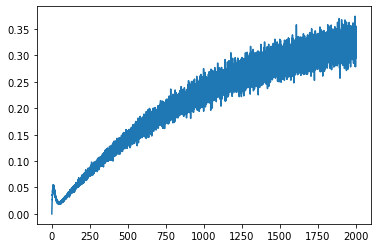

In [136]:
plt.plot(data_t, ysynth)

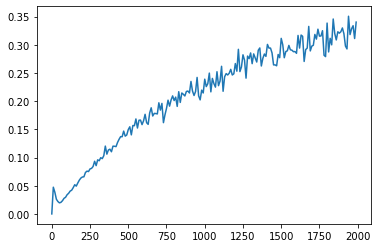

In [137]:
downsample_t = data_t[::100]
ydwn = ysynth[::100]

plt.plot(downsample_t, ydwn)

In [138]:
problem = pypei.Problem()

In [139]:
problem.build_model(
    model_fn=single_jump_model,
    model_form = {
        'state': 2,
        'parameters': 9,
    },
    time_span=tlim,
    grid_size=400,
    basis_number=7,
    knot_fn=lambda *x : [0, 50, 500, 1000, 2000]
)

In [140]:
def obsv_ca(t, y, p):
    a, r = ca.horzsplit(y, 1)
    *p_, g = p
    return g * a * r * (V - EK)


In [141]:
interpolant = obsv_ca(downsample_t, problem.model.all_x_at(problem.model.cs, downsample_t), problem.model.ps)

In [142]:
problem.data_time = downsample_t
problem.data_orig = ydwn.reshape((-1, 1))
problem.data = ydwn.reshape((-1, 1))

problem.interpolator = interpolant

In [147]:
model_struct = {
    'order':'ar',
    'inherent_order': 'ar',
}
problem.build_objective(model_struct, balance=False)

In [155]:
problem.build_solver(constraint_opts={'ubg': 1}, guess_opts={'x0': 0.75}, w0=[1]*200+[1e-1, 1e-1], 
                     weight_bounds=[(0, 1/0.15)]*200 + [(0, np.inf), (0, np.inf)])

In [156]:
sln = problem.solve()

Iteration: 0
This is Ipopt version 3.14.8, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3188
Number of nonzeros in Lagrangian Hessian.............:      172

Total number of variables............................:       23
                     variables with only lower bounds:        9
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8477775e+03 0.00e+00 9.90e+01  -1.0 0.00e+00    -  0.00e+

MUMPS returned INFO(1) = -9 and requires more memory, reallocating.  Attempt 1
  Increasing icntl[13] from 1000 to 2000.
MUMPS returned INFO(1) = -9 and requires more memory, reallocating.  Attempt 2
  Increasing icntl[13] from 2000 to 4000.
MUMPS returned INFO(1) = -9 and requires more memory, reallocating.  Attempt 3
  Increasing icntl[13] from 4000 to 8000.
  50  1.7171188e+04 0.00e+00 1.39e+02  -3.8 1.35e-03  -1.6 9.18e-01 1.00e+00f  1 
 100  1.3090262e+00 0.00e+00 9.60e-04  -8.6 1.04e-05  -2.2 1.00e+00 1.00e+00h  1 
 150  1.3064553e+00 0.00e+00 2.50e+00  -8.6 1.80e-04  -3.5 1.00e+00 1.00e+00h  1 
 200  1.3034674e+00 0.00e+00 3.62e-02  -8.6 3.72e-05  -2.9 1.00e+00 1.00e+00h  1 
 250  1.3009309e+00 0.00e+00 1.21e-05  -8.6 1.12e-06  -1.5 1.00e+00 1.00e+00h  1 
 300  1.2990825e+00 0.00e+00 1.17e+00  -8.6 1.42e-04  -3.7 1.00e+00 1.00e+00h  1 
 350  1.2975369e+00 0.00e+00 1.94e-04  -8.6 5.76e-07  -1.4 1.00e+00 1.00e+00h  1 
 400  1.2965306e+00 0.00e+00 6.04e-03  -8.6 8.30e-06  -2.6 1.00

 650  1.9840087e+09 0.00e+00 9.72e+04  -1.0 4.57e-05   3.5 1.00e+00 1.00e+00f  1 
 700  1.9831777e+09 0.00e+00 6.00e+04  -1.0 9.82e-05   3.1 1.00e+00 1.00e+00f  1 
 750  1.9823043e+09 0.00e+00 5.95e+06  -1.0 2.27e-04   2.7 1.00e+00 1.00e+00f  1 
 800  1.9813990e+09 0.00e+00 8.69e+04  -1.0 1.73e-05   4.1 1.00e+00 1.00e+00f  1 
 850  1.9804023e+09 0.00e+00 6.98e+04  -1.0 1.79e-05   3.8 1.00e+00 1.00e+00f  1 
 900  1.9792599e+09 0.00e+00 2.44e+04  -1.0 9.41e-06   4.3 1.00e+00 1.00e+00f  1 
 950  1.9778173e+09 0.00e+00 2.95e+05  -1.0 8.74e-05   3.0 1.00e+00 1.00e+00f  1 
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.9765520e+09 0.00e+00 7.42e+06  -1.0 2.13e-04   2.6 1.00e+00 1.00e+00f  1 
1050  1.9754800e+09 0.00e+00 2.12e+04  -1.0 9.50e-06   4.1 1.00e+00 1.00e+00f  1 
1100  1.9736468e+09 0.00e+00 2.66e+06  -1.0 1.09e-04   2.8 1.00e+00 1.00e+00f  1 
1150  1.9720018e+09 0.00e+00 2.24e+05  -1.0 3.72e-05   3.3 1.00e+00 1.00e+00f  1 
1200  1.9704193e+

C:\Users\dwu\REPOS\pypei\pypei\irls_fitter.py:233: StepControlWarning: Log-Likelihood is not improving: 13.177723476158537
  warnings.warn(f"Log-Likelihood is not improving: {err}", category=Solver.StepControlWarning)


Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   3.4010596850926643e+21    3.4010596850926643e+29
Dual infeasibility......:   5.8132443836092564e+23    5.8132443836092560e+31
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.0158793625724093e-11    6.0158793625724087e-03
Overall NLP error.......:   5.8132443836092564e+23    5.8132443836092560e+31


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 2
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 17
Number of equality constraint Jacobian evalu

C:\Users\dwu\REPOS\pypei\pypei\irls_fitter.py:233: StepControlWarning: Log-Likelihood is not improving: 1.0
  warnings.warn(f"Log-Likelihood is not improving: {err}", category=Solver.StepControlWarning)


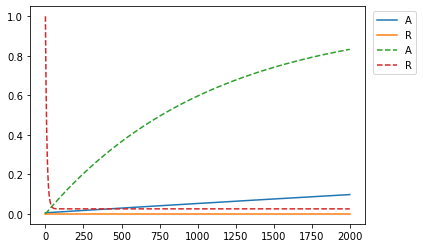

In [164]:
plt.figure()
plt.plot(problem.model.observation_times, problem.get_state(sln['shist'][2]), label=['A', 'R'])
plt.plot(ts, ar_sol.sol(ts).T, '--', label=['A', 'R'])
plt.legend(bbox_to_anchor=[1.01, 1])

(0.0, 0.35)

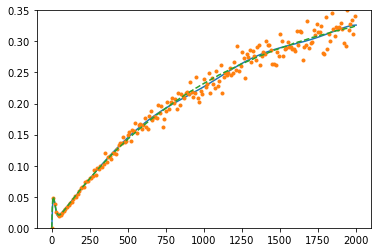

In [162]:
plt.plot(problem.model.observation_times, 
         obsv_ca(problem.model.observation_times,  problem.get_state(sln['shist'][1]), problem.get_parameters(sln['shist'][1])))
plt.plot(downsample_t, ydwn, '.')
plt.plot(data_t, truth, '--')

plt.ylim(0, 0.35)

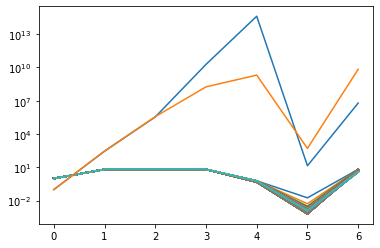

In [159]:
plt.semilogy(sln['whist']);

In [163]:
[problem.get_parameters(s) for s in sln['shist']]

[(DM(0.000199199),
  DM(0.0500025),
  DM(100000),
  DM(100000),
  DM(9.58384e-05),
  DM(0.0500052),
  DM(100000),
  DM(100000),
  DM(0.0162486)),
 (DM(1.47013e-07),
  DM(0.053401),
  DM(100000),
  DM(100000),
  DM(0.000456974),
  DM(0.0500011),
  DM(100000),
  DM(100000),
  DM(24947.5)),
 (DM(1.63475e-05),
  DM(0.054495),
  DM(100000),
  DM(100000),
  DM(1.56592e-05),
  DM(0.0507874),
  DM(100000),
  DM(100000),
  DM(15758.9)),
 (DM(8.58062e-07),
  DM(0.051376),
  DM(100000),
  DM(100000),
  DM(0.000243),
  DM(0.0506036),
  DM(100000),
  DM(100000),
  DM(15758.6)),
 (DM(0.0117046),
  DM(0.0514344),
  DM(100000),
  DM(100000),
  DM(0.0117046),
  DM(0.0506629),
  DM(100000),
  DM(100000),
  DM(15758.6)),
 (DM(2.53257e-05),
  DM(0.0500197),
  DM(100000),
  DM(100000),
  DM(2.01177e-05),
  DM(0.0500248),
  DM(100000),
  DM(100000),
  DM(0.00323682))]

In [122]:
p_true

[0.000226,
 0.0699,
 3.45e-05,
 0.05462,
 0.0873,
 0.00891,
 0.00515,
 0.03158,
 0.1524]